In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math

## Personal Part

### Description of the responsibility in the project

placeholder

### 1. Read the Data

In [2]:
df = pd.read_csv("/Users/yunzheyu/Desktop/Classes/BA476/Group Project/archive/spotify_songs.csv")

### 2. Clean the data

In [3]:

# Handling Missing Values
# Since missing values are in 'track_name', 'track_artist', and 'track_album_name', we'll drop rows with any missing information
df.dropna(subset=['track_name', 'track_artist', 'track_album_name'], inplace=True)

# Removing Duplicates
df = df.drop_duplicates()

# Standardizing Numerical Columns
# For illustration, let's standardize the 'loudness' and 'tempo' columns
scaler = StandardScaler()
df[['loudness', 'tempo']] = scaler.fit_transform(df[['loudness', 'tempo']])

# Checking the dataframe after cleaning
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32828 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32828 non-null  int64  
 4   track_album_id            32828 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32828 non-null  object 
 7   playlist_name             32828 non-null  object 
 8   playlist_id               32828 non-null  object 
 9   playlist_genre            32828 non-null  object 
 10  playlist_subgenre         32828 non-null  object 
 11  danceability              32828 non-null  float64
 12  energy                    32828 non-null  float64
 13  key                       32828 non-null  int64  
 14  loudne

### 3. Feature Selections and Engineering

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
# Assuming df is your cleaned DataFrame

# Example: Feature Engineering
# Creating a new feature 'loudness_energy_ratio'
df['loudness_energy_ratio'] = df['loudness'] / df['energy']

# Standardizing the dataset for PCA
features = ['danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness_energy_ratio']
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Applying PCA
pca = PCA(n_components=2)  # Adjust n_components based on your analysis
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal_component_1', 'principal_component_2'])

# Analyzing Feature Importance with Random Forest
rf = RandomForestClassifier()
rf.fit(df[features], df['playlist_genre']) 
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

print("Feature Importances:\n", feature_importance)
print("PCA Component Analysis:\n", pca.explained_variance_ratio_)

Feature Importances:
 tempo                    0.136694
speechiness              0.127038
danceability             0.123035
energy                   0.104309
valence                  0.100602
acousticness             0.098135
instrumentalness         0.080221
loudness                 0.078264
loudness_energy_ratio    0.078164
liveness                 0.073538
dtype: float64
PCA Component Analysis:
 [0.21548308 0.15105717]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


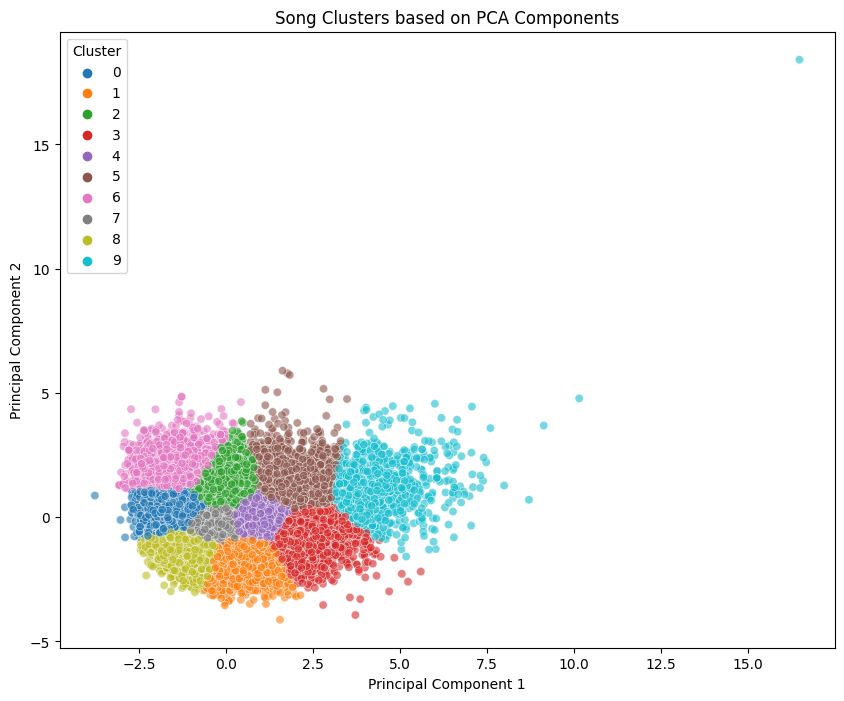

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns

# Focusing on key features identified from feature importance
key_features = ['danceability', 'energy', 'loudness_energy_ratio']
X = df[key_features]

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust n_clusters based on your analysis
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster labels to your dataframe
df['cluster'] = clusters

# Now, df includes a 'cluster' column indicating the assigned cluster for each song
# Applying KMeans clustering on PCA components
kmeans_pca = KMeans(n_clusters=10, random_state=42)
principalDf['cluster'] = kmeans_pca.fit_predict(principalDf[['principal_component_1', 'principal_component_2']])
# principalDf now includes a 'cluster' column based on simplified PCA components

# Visualizing the clusters from PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(data=principalDf, x='principal_component_1', y='principal_component_2', hue='cluster', palette='tab10', alpha=0.6)
plt.title('Song Clusters based on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


### 4. Regularized Regression Model(without feature selected)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Define features and target
X = df.drop('track_popularity', axis=1)
y = df['track_popularity']

# Select categorical columns with relatively few unique values for one-hot encoding
categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 10 and 
                    X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if 
                  X[cname].dtype in ['int64', 'float64']]

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Pipeline for feature selection using Lasso
feature_selection = SelectFromModel(Lasso(alpha=0.05))

# Ridge regression model pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('regressor', Ridge(alpha=1.0))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Ridge Regression after Feature Selection:", mse)
